In [394]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import nengo
from nengo.utils.least_squares_solvers import LSMRScipy
from nengolib import RLS, Network
from nengolib.neurons import Tanh
from scipy.interpolate import Rbf, CubicSpline
from rbf.pde.nodes import disperse, poisson_disc_nodes
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from numpy.random import default_rng


In [591]:

seed=21
rng = default_rng(seed)

d_inputs = 2
d_outputs = 1

field_width = 0.5
field_eps = field_width / 2

mem_dimension = 1. 
vert = np.array([[-mem_dimension,-mem_dimension],[-mem_dimension,mem_dimension],
                 [mem_dimension,mem_dimension],[mem_dimension,-mem_dimension]])
smp = np.array([[0,1],[1,2],[2,3],[3,0]])

nodes, groups, _ = poisson_disc_nodes(field_width, (vert, smp))
input_centers = nodes
n_units = int(input_centers.shape[0])
print(input_centers.shape)
n_inputs = 5000 

(16, 2)


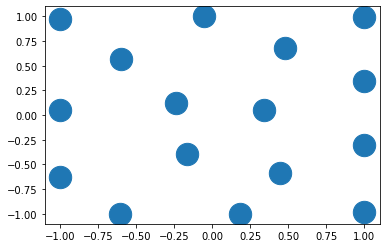

In [592]:
plt.figure()
plt.scatter(np.asarray(input_centers[:,0]).reshape((-1,)), 
            np.asarray(input_centers[:,1]).reshape((-1,)),
             s=field_width*1000.);


In [593]:
input_ip_dict = {}
for i, X in enumerate(input_centers):
    x_obs = np.asarray(X).flatten()
    u_obs = np.asarray([[1.0]]).flatten()
    rbf_args = np.concatenate((x_obs, u_obs))
    input_ip_dict[i] = Rbf(*rbf_args, function='gaussian', epsilon=field_eps)


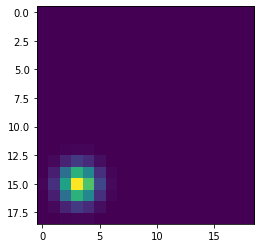

In [596]:
input_meshgrid = np.meshgrid(*[np.linspace(-1.5, 1.5, num=19) for d in range(d_inputs)], indexing='ij')
X_train = np.column_stack([ x.flatten() for x in input_meshgrid])
input_maps = []
for i in range(len(input_ip_dict)):
    input_map = input_ip_dict[i](*X_train.T)
    input_map[(input_map < 1e-2)] = 0.
    input_maps.append(input_map.ravel())
input_map_matrix = np.column_stack(input_maps)
y_train = input_map_matrix

plt.imshow(y_train[:,0].reshape(19,19));

In [597]:
learning_rate = 0.01
solver = nengo.solvers.LstsqL2(solver=LSMRScipy(), reg=0.001)
#solver = nengo.solvers.LstsqDrop(drop=0.25, solver1=solver)


ens_params = dict(
    max_rates=nengo.dists.Choice([20.]),
    intercepts=nengo.dists.Choice([0.1]),
)
print(X_train.shape)
print(y_train.shape)

(361, 2)
(361, 16)


In [607]:
am_model = Network(seed=seed)

with am_model:
    am_ensembles = {}
    am_conns = {}
    target_val = nengo.Node(None, size_in=d_outputs)
    am_input = nengo.Ensemble(n_neurons=n_inputs, dimensions=d_inputs, 
                              neuron_type=nengo.RectifiedLinear(),
                              eval_points=X_train,
                              **ens_params)

    am_memory = nengo.Ensemble(n_neurons=n_units, dimensions=d_outputs, radius=10.,
                               neuron_type=nengo.LIFRate())
    #fb_transform = 2. * np.eye(n_units) - 1.
    #nengo.Connection(am_memory.neurons, am_memory.neurons, transform=fb_transform)
    
    am_output = nengo.Ensemble(n_neurons=n_units, dimensions=d_outputs,
                               neuron_type=nengo.LIFRate())
                               
    am_error = nengo.Ensemble(n_neurons=n_units, dimensions=d_outputs,
                              neuron_type=nengo.LIFRate())
                              
    learn_conn = nengo.Connection(am_memory, am_output, 
                                  function=lambda x:[ 0. ],
                                  learning_rule_type=RLS(learning_rate, pre_synapse=0.005),
                                  synapse=None)
    
    nengo.Connection(am_output, am_error)
    nengo.Connection(target_val, am_error, transform=-1)
    nengo.Connection(am_error, learn_conn.learning_rule)
    
    
    inhib_learning = nengo.Node(None, size_in=1)
    nengo.Connection(inhib_learning, am_error.neurons, transform=[[-2]] * am_error.n_neurons)

    for item in range(n_units):
        
        am_ens = nengo.Ensemble(n_neurons=1, dimensions=d_outputs,
                                neuron_type=nengo.LIFRate(),
                                **ens_params)
        
                                             
        am_conn = nengo.Connection(am_input, am_ens, 
                                   synapse=nengo.Lowpass(0.01),
                                   eval_points=X_train, 
                                   function=y_train[:,item].reshape((-1,1)),
                                   solver=solver)
        
        
        am_ensembles[item] = am_ens
        am_conns[item] = am_conn

        ff_transform = (np.zeros(n_units) - 1.)
        ff_transform[item] = 1.
        nengo.Connection(am_ens, am_memory.neurons, transform=ff_transform.reshape((-1,1)), 
                         synapse=nengo.Lowpass(0.01))
                        
       

In [608]:
sim =  nengo.Simulator(am_model)
_, train_acts = nengo.utils.ensemble.tuning_curves(am_input, sim, inputs=X_train)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

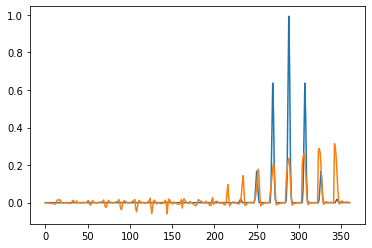

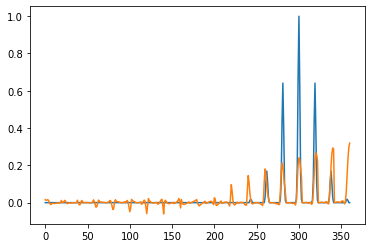

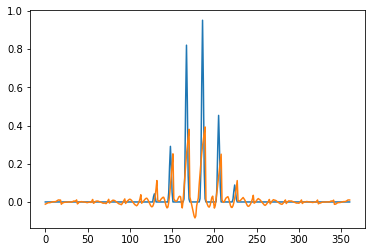

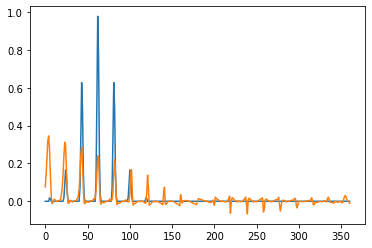

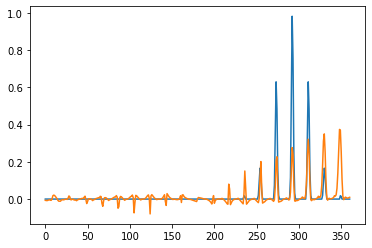

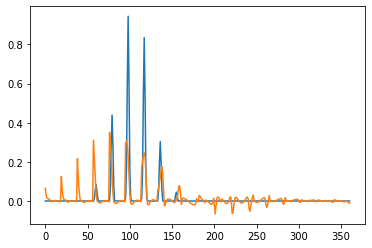

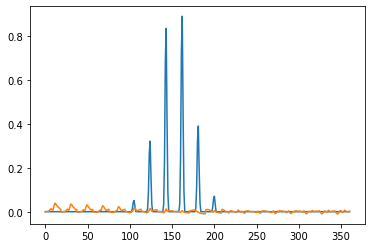

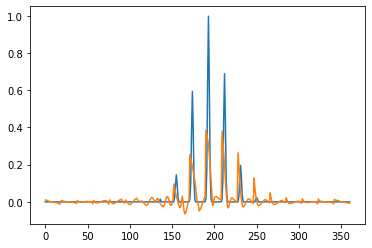

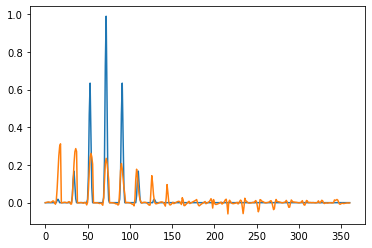

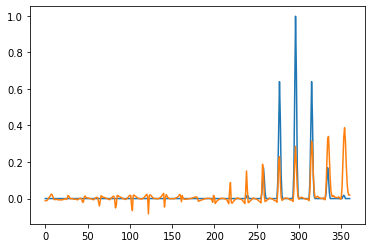

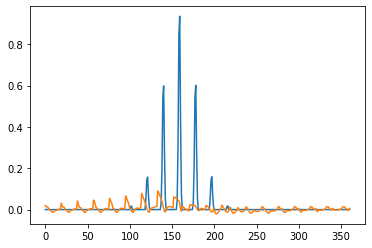

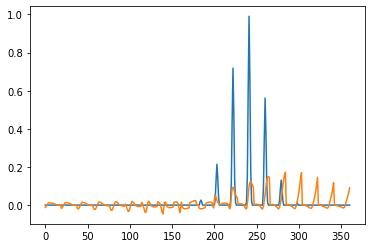

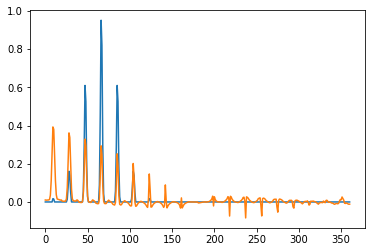

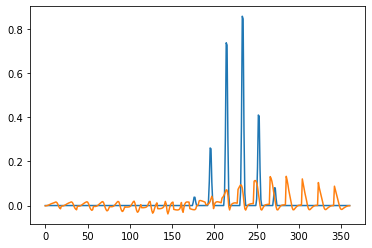

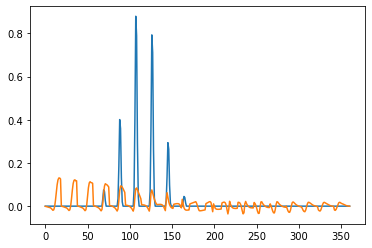

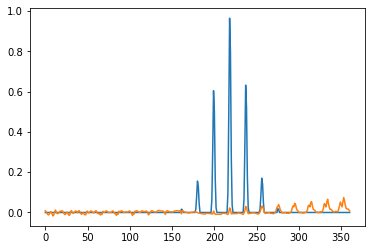

In [609]:
for i in range(len(am_conns)):
    output_weights = sim.data[am_conns[i]].weights
    plt.figure()
    plt.plot(y_train[:,i]);
    plt.plot(np.dot(train_acts, output_weights.T));


In [610]:
n_items = 5

rng = np.random.RandomState(seed=seed)
keys = nengo.dists.UniformHypersphere(surface=True).sample(
    n_items, d_inputs, rng=rng)
values = nengo.dists.UniformHypersphere(surface=False).sample(
    n_items, d_outputs, rng=rng)

In [611]:
dt = 0.001
period = 0.5
T = period * n_items * 2


In [612]:
with am_model:
    
    stim_values = nengo.Node(output=nengo.processes.PresentInput(values, presentation_time=period))
    stim_keys = nengo.Node(output=nengo.processes.PresentInput(keys, presentation_time=period))
    learning = nengo.Node(output=lambda t: int(t >= T / 2))
    recall = nengo.Node(size_in=d_outputs)
    Connection(learning, inhib_learning, synapse=None)
    Connection(stim_keys, am_input)
    Connection(stim_values, target_val)
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_output = nengo.Probe(am_output)
    p_inhib_learning = nengo.Probe(inhib_learning)
    p_learning = nengo.Probe(learning)
    p_error = nengo.Probe(am_error)
    p_input = nengo.Probe(am_input)
    p_memory = nengo.Probe(am_memory)
    p_memory_rates = nengo.Probe(am_memory.neurons, 'rates')
#    p_ens = [ nengo.Probe(am_ensembles[i]) for i in range(n_units) ]
    
#    p_output_rates = nengo.Probe(am_output.neurons, 'rates')

In [613]:
sim =  nengo.Simulator(am_model, dt=dt)
sim.run(T)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

(5000, 16)


Text(0, 0.5, 'Neuron number')

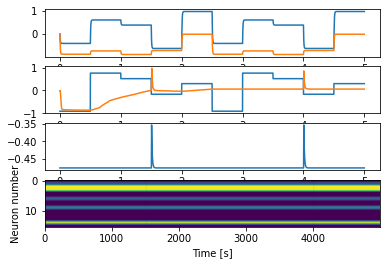

In [614]:
plt.figure()

plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[p_input])
plt.subplot(4, 1, 2)
plt.plot(sim.trange(), sim.data[p_values])
plt.plot(sim.trange(), sim.data[p_output])
plt.subplot(4, 1, 3)
plt.plot(sim.trange(), sim.data[p_memory])
print(sim.data[p_memory_rates].shape)
plt.subplot(4, 1, 4)
plt.imshow(sim.data[p_memory_rates].T,aspect='auto')
plt.xlabel("Time [s]")
plt.ylabel("Neuron number")

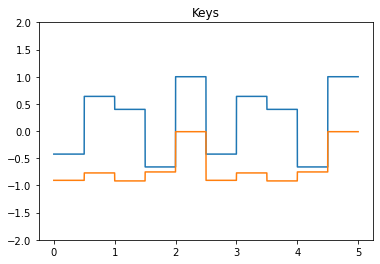

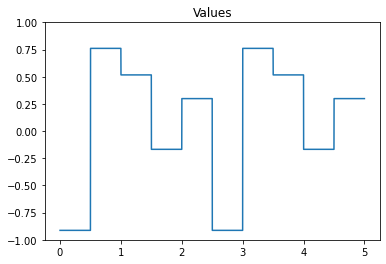

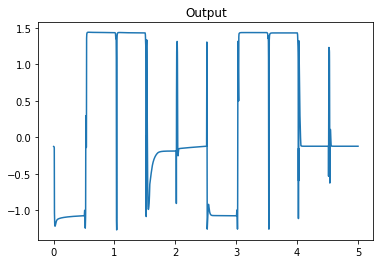

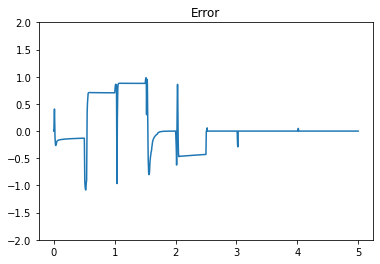

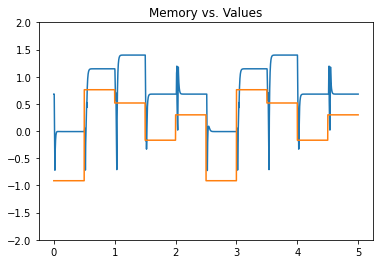

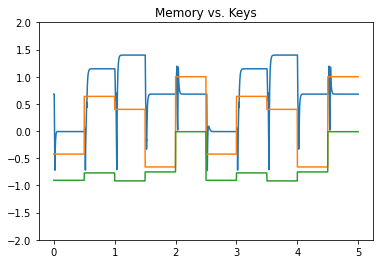

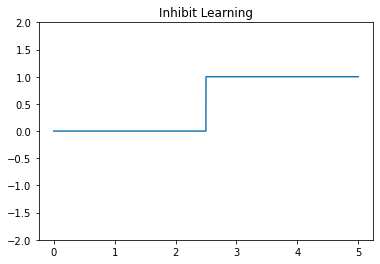

In [565]:
plt.figure()
plt.title("Keys")
plt.plot(t, sim.data[p_keys])
plt.ylim(-2, 2)

plt.figure()
plt.title("Values")
plt.plot(t, sim.data[p_values])
plt.ylim(-1, 1)

plt.figure()
plt.title("Output")
plt.plot(t, sim.data[p_output])
#plt.ylim(-1.0, 1.0);

plt.figure()
plt.title("Error")
plt.plot(t, sim.data[p_error])
plt.ylim(-2.0, 2.0);

plt.figure()
plt.title("Memory vs. Values")
plt.plot(t, sim.data[p_memory])
plt.plot(t, sim.data[p_values])
plt.ylim(-2.0, 2.0);

plt.figure()
plt.title("Memory vs. Keys")
plt.plot(t, sim.data[p_memory])
plt.plot(t, sim.data[p_keys])
plt.ylim(-2.0, 2.0);

plt.figure()
plt.title("Inhibit Learning")
plt.plot(t, sim.data[p_learning])
plt.ylim(-2.0, 2.0);